# Unscented Kalman Filter SLAM

In [1]:
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
%matplotlib notebook

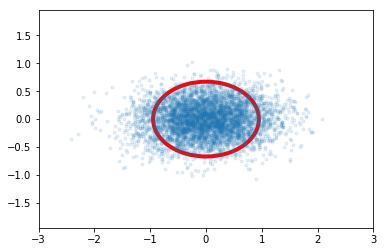

In [2]:
num_samples = 5000
covar = np.matrix(
    [
        [0.6, 0.0],
        [0.0, 0.3]
    ]
)
x = np.random.normal(loc=0, scale=covar[0, 0], size=num_samples)
y = np.random.normal(loc=0, scale=covar[1, 1], size=num_samples)
# decompose eigenvalues
# convert eigenvalues to the major and minor axis length
# of the 95% confidence ellipse
def covar_to_radius(covar):
    v = np.linalg.eigvals(covar)
    v = np.apply_along_axis(lambda x: np.sqrt(5.991*x), 0, v)
    return v
v = covar_to_radius(covar)

fig, ax = plt.subplots()
plt.plot(x, y, '.', alpha=0.1)
he = Ellipse([0,0], width=v[0], height=v[1], fill=False, linewidth=4, color='r')
ax.add_artist(he)
plt.axis('equal');

plt.xlim([-3, 3])
plt.ylim([-3, 3]);

## Sigma points example

In [19]:
class SigmaPoints():
    n_dim = 2
    n_sigma_points = 2 * n_dim + 1

    alpha = 0.25
    beta  = 2
    kappa = 3
    lmda  = alpha**2 * (n_dim + kappa) - n_dim
    
    def __init__(self, n_dim, kappa=3, alpha=0.25, beta=2):
        self.n_dim = n_dim
        self.n_sigma_points = 2 * n_dim + 1
        self.kappa = kappa
        self.alpha = alpha
        self.beta = beta
        self.lmda = self.alpha**2 * (n_dim + self.kappa) - n_dim
     
    # private helper method
    @classmethod
    def __update_stats__(self):
        self.mu = np.zeros_like(self.mu, dtype=float)
        self.covar = np.array(self.mu)
        # update mean and covariance
        for i in range(self.n_sigma_points):
            self.mu += self.wm[i] * self.sigma_pts[i, :]
        print(f'mu = {self.mu}, done!')
        for i in range(self.n_dim):
            self.covar[2*i+1, :] += self.wc[i] * (self.sigma_pts[i, :] - self.mu) * (self.sigma_pts[i, :] - self.mu).T
        self.covar = np.diag(self.covar)
    
    @classmethod
    def from_mu_covar(self, mu, covar):  
        # store statistics
        self.mu = mu
        self.covar = covar
        # sigma pointst
        self.sigma_pts = np.empty([self.n_sigma_points, self.n_dim])
        self.wm = np.empty([self.n_sigma_points]) # weight for mean (1st moment)
        self.wc = np.empty([self.n_sigma_points]) # weight for covariance (2nd moment)
        self.sigma_pts[0, :] = mu
        self.wm[0] = self.lmda / (self.n_dim + self.lmda)
        self.wc[0] = self.wm[0] + 1 - self.alpha**2 + self.beta
        # Compute Sigma points
        rhs = np.sqrt( (self.n_dim + self.lmda) * covar)
        w = 1 / (2 * (self.n_dim + self.lmda))
        for i in range(1, self.n_sigma_points):
            # Sigma points
            if i <= self.n_dim:
                self.sigma_pts[i, :] = mu + rhs[i-1, :]
            else:
                self.sigma_pts[i, :] = mu - rhs[i-1-self.n_dim, :]
            # weight for mean
            self.wm[i] = self.wc[i] = w
    
    @classmethod
    def get_bounding_ellipse(self, line_width=2, color='r'):
        # return axis length for the 95% CI bounding ellipse
        v, vec = np.linalg.eig(self.covar)
        v = np.apply_along_axis(lambda x: np.sqrt(5.991*x), 0, v)
        angle = vec[0, :]
        he = Ellipse(self.mu, width=v[0], height=v[1], fill=False, linewidth=line_width, color=color)
        return he
    
    @classmethod
    def transform(self, fun):
        self.sigma_pts = np.apply_along_axis(fun, 1, self.sigma_pts)
        self.__update_stats__()

In [12]:
sp.sigma_pts

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.30618622],
       [ 0.        , -0.30618622],
       [-0.4330127 ,  0.        ],
       [ 0.        , -0.30618622]])

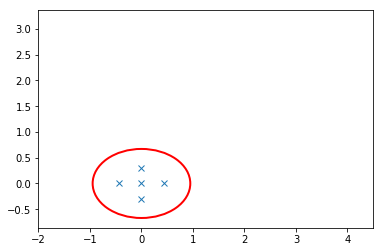

In [20]:
sp = SigmaPoints(2)
sp.from_mu_covar([0,0], np.diag([0.6, 0.3]))
he = sp.get_bounding_ellipse()

# visualize
fig, ax = plt.subplots()
ax.add_artist(he)
plt.plot(sp.sigma_pts[:, 0], sp.sigma_pts[:, 1], 'x')

# transform
def tf1(x): return x + [-1, 1]
def tf2(x): return np.array(
    [
        3 + x[0] + np.sin(2 * x[0]) + np.cos(x[1]),
        1 + np.cos(0.2 * x[1])
    ]
)

# sp.transform(tf1)
# he1 = sp.get_bounding_ellipse(color='b')
# plt.plot(sp.sigma_pts[:, 0], sp.sigma_pts[:, 1], 'x')
# ax.add_artist(he1)

# sp.transform(tf2)
# he2 = sp.get_bounding_ellipse(color='g')
# plt.plot(sp.sigma_pts[:, 0], sp.sigma_pts[:, 1], 'x')
# ax.add_artist(he2)

plt.axis('equal');

plt.xlim([-2, 4.5])
plt.ylim([-2, 4.5]);

In [95]:
sp.sigma_pts[1, :] * sp.sigma_pts[1, :]

array([4.27337441, 3.92066365])

In [90]:
sp.covar

array([[2.30645279e+00, 0.00000000e+00],
       [0.00000000e+00, 5.50796646e-04]])